In [56]:
from scipy.io import loadmat
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import gc
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras 

In [47]:
X_train = np.array(np.load('D:\Akanksha\IIT Mandi\Sem1\Winter Project-iHub\Transformer\X_train.npz')['arr_0'], dtype=np.float16)
X_val = np.array(np.load('D:\Akanksha\IIT Mandi\Sem1\Winter Project-iHub\Transformer\X_val.npz')['arr_0'], dtype=np.float16)
y_train = np.array(np.load('D:\Akanksha\IIT Mandi\Sem1\Winter Project-iHub\Transformer\y_train.npz')['arr_0'])
y_val = np.array(np.load('D:\Akanksha\IIT Mandi\Sem1\Winter Project-iHub\Transformer\y_val.npz')['arr_0'])

In [34]:
num_layers = 3
d_model = 64
dff = 128
num_heads = 8

In [31]:
print(X_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train.shape)
print(y_train[56], y_train[75])
print(X_train[7])

(19872, 128, 64)
(4800, 128, 64)
(4800,)
(19872,)
1 0
[[ -4.086   -1.558    4.2    ...  -5.367   -4.28    -5.066 ]
 [ -7.812   -7.6     -2.275  ... -11.7    -10.914  -11.15  ]
 [ -8.18    -9.66    -7.13   ... -10.375   -9.81   -10.04  ]
 ...
 [ -3.912   -6.605   -0.323  ...   0.6543   0.0547  -0.9663]
 [ -6.836   -9.164   -2.215  ...   1.083    1.574    0.7114]
 [ -9.49   -12.19    -4.26   ...   0.2031   0.1766   0.8345]]


In [32]:
""" Sinusoidal Positional Embedding """
class Sinusoidal_PE(tf.keras.layers.Layer):
    
    def __init__(self, maxlen, embed_dim):
        
        #### Defining Essentials
        super().__init__()
        self.maxlen = maxlen # Maximum Sequence Length
        self.embed_dim = embed_dim # Embedding Dimensions of the Positional Encodings                                           

        #### Defining Layers
        position_embedding_matrix = self.get_position_encoding(self.maxlen, self.embed_dim)
        self.position_embedding_layer = tf.keras.layers.Embedding(
            input_dim=self.maxlen, output_dim=self.embed_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'maxlen': self.maxlen, 
            'embed_dim': self.embed_dim 
        })
        return config 
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                #denominator = np.power(n, 2*i/d)
                #P[k, 2*i] = np.sin(k/denominator)
                #P[k, 2*i+1] = np.cos(k/denominator)
                P[k,2*i] = np.sin(k*2*i)
                P[k,2*i+1] = np.cos(k*(2*i+1))
        return P
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-2])
        embedded_indices = self.position_embedding_layer(position_indices)
        return inputs+embedded_indices

In [12]:
""""Attention"""
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention): 
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [13]:
"""FEED FORWARD NETWORK"""
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):

        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        ])

        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        # print("Shape of input after add: ", x.shape)
        x = self.layer_norm(x)
        # print("Shape of input after normalization: ", x.shape)
        return x

In [14]:
"""THE ENCODER layer"""
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        # print("Shape of input after Attention: ", x.shape)
        x = self.ffn(x)
        # print("Shape of input after feedforward: ", x.shape)
        return x

In [15]:
"""ENCODER"""
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        

        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff) for _ in range(num_layers)]
        
        # self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # # Add dropout.
        # x = self.dropout(x)
        # print("Shape of input after dropout: ", x.shape)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
            # print("Shape of input after encoder layer ", i,": ", x.shape)

        return x  # Shape `(batch_size, seq_len, d_model)`

In [16]:

"""TRANSFORMER"""
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, timesteps_each_segment):
        super().__init__()
        # self.intial_layer = tf.keras.layers.Conv1D(filters=64, kernel_size = (3, 3))
        self.convLayers = tf.keras.Sequential([ tf.keras.layers.Conv1D(filters=64, kernel_size=3),
                                                tf.keras.layers.Conv1D(filters=64, kernel_size=3)
                                               ])
        
        self.pos_encoding = Sinusoidal_PE(timesteps_each_segment, d_model)
        
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff)


        self.final_layer =  tf.keras.Sequential([ tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        eeg_data = inputs
        eeg_data = self.convLayers(eeg_data)
        eeg_data = self.pos_encoding(eeg_data)
        eeg_data = self.encoder(eeg_data)  # (batch_size, eeg_data_len, d_model)

        # Final linear layer output.
        final_output = self.final_layer(eeg_data)  # (batch_size, target_len, target_vocab_size)
        # print("FINAL OUTPUT SHAPE: ", final_output.shape)

        # Return the final output and the attention weights.
        return final_output

In [37]:
"""Calling Transformer"""
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, timesteps_each_segment=128)

# attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
# print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
transformer.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) #SGD #learning_rate
#sparse_categorical

In [38]:

"""MODEL CHECKPOINTING"""
# filepath= "D:\BCI\Datasets\KUL_new_version\bestmodel.h5"
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,mode='max')
# checkpoint_dir = os.path.dirname(checkpoint_path)
filepath= "./Models/AAD_Transformer.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)


In [62]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=False, save_best_only=False, verbose=1, period=1)

history=transformer.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
156/156 [==============================] - 1498s 10s/step - loss: 0.3464 - accuracy: 0.8508 - val_loss: 0.8126 - val_accuracy: 0.6079
Epoch 2/100
156/156 [==============================] - 1471s 9s/step - loss: 0.3379 - accuracy: 0.8565 - val_loss: 0.7791 - val_accuracy: 0.6160
Epoch 3/100
156/156 [==============================] - 1475s 9s/step - loss: 0.3406 - accuracy: 0.8550 - val_loss: 0.7635 - val_accuracy: 0.6323
Epoch 4/100
156/156 [==============================] - 1467s 9s/step - loss: 0.3396 - accuracy: 0.8541 - val_loss: 0.7539 - val_accuracy: 0.6344
Epoch 5/100
156/156 [==============================] - 1465s 9s/step - loss: 0.3314 - accuracy: 0.8592 - val_loss: 0.8048 - val_accuracy: 0.6081
Epoch 6/100
156/156 [==============================] - 1474s 9s/step - loss: 0.3355 - accuracy: 0.8550 - val_loss: 0.7523 - val_accuracy: 0.6377
Epoch 7/100
156/156 [==============================] - 1499s 10s/step - loss: 0.3338 - accuracy: 0.8571 - val_loss: 0.7677 - val_

156/156 [==============================] - 1464s 9s/step - loss: 0.2181 - accuracy: 0.9236 - val_loss: 0.9543 - val_accuracy: 0.6190
Epoch 57/100
156/156 [==============================] - 1469s 9s/step - loss: 0.2191 - accuracy: 0.9196 - val_loss: 1.0497 - val_accuracy: 0.6183
Epoch 58/100
156/156 [==============================] - 1461s 9s/step - loss: 0.2208 - accuracy: 0.9195 - val_loss: 0.9494 - val_accuracy: 0.6179
Epoch 59/100
156/156 [==============================] - 1465s 9s/step - loss: 0.2231 - accuracy: 0.9176 - val_loss: 0.9092 - val_accuracy: 0.6333
Epoch 60/100
156/156 [==============================] - 1467s 9s/step - loss: 0.2171 - accuracy: 0.9229 - val_loss: 0.9489 - val_accuracy: 0.6288
Epoch 61/100
156/156 [==============================] - 1467s 9s/step - loss: 0.2115 - accuracy: 0.9265 - val_loss: 1.0120 - val_accuracy: 0.6162
Epoch 62/100
156/156 [==============================] - 1501s 10s/step - loss: 0.2151 - accuracy: 0.9230 - val_loss: 0.9359 - val_accurac

In [63]:
#### print("============================Transformer Summary============================")
print(transformer.summary())

accuracy1 = transformer.evaluate(X_val, y_val)
accuracy2 = transformer.evaluate(X_train, y_train)

print("Accuracy on val: ", accuracy1)
print("Accuracy on train: ", accuracy2)

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 124, 64)           24704     
                                                                 
 sinusoidal_pe_2 (Sinusoidal  multiple                 8192      
 _PE)                                                            
                                                                 
 encoder_2 (Encoder)         multiple                  448512    
                                                                 
 sequential_15 (Sequential)  (None, 1)                 7937      
                                                                 
Total params: 489,345
Trainable params: 481,153
Non-trainable params: 8,192
_________________________________________________________________
None
621/621 [==============================] - 606s 974ms/step - loss: 0.2321 - accuracy: 0.8969
Accuracy on

150/150 [==============================] - 150s 1s/step
---------------Confusion Matrix---------------


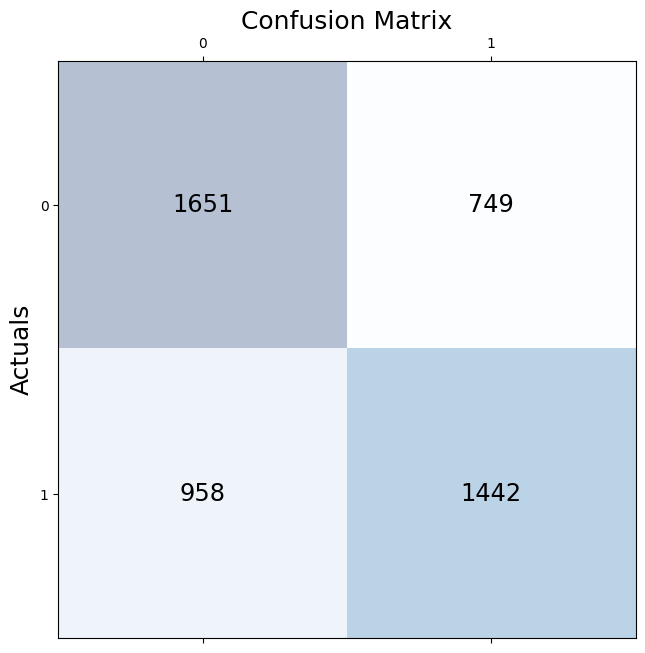

Accuracy on val [0.8272721767425537, 0.6443750262260437]
Accuracy on train [0.2797434329986572, 0.8856179714202881]


In [64]:
transformer.load_weights(filepath)
accuracy1 = transformer.evaluate(X_val, y_val)
accuracy2 = transformer.evaluate(X_train, y_train)


"""Confusion Matrix"""
y_pred = transformer.predict(X_val)
y_pred1 = []
for k in y_pred:
     if k > 0.5:
        y_pred1.append(1)
     else:
        y_pred1.append(0)

y_pred1 = np.array(y_pred1)

conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred1)
print("---------------Confusion Matrix---------------")
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("Accuracy on val", accuracy1)
print("Accuracy on train", accuracy2)

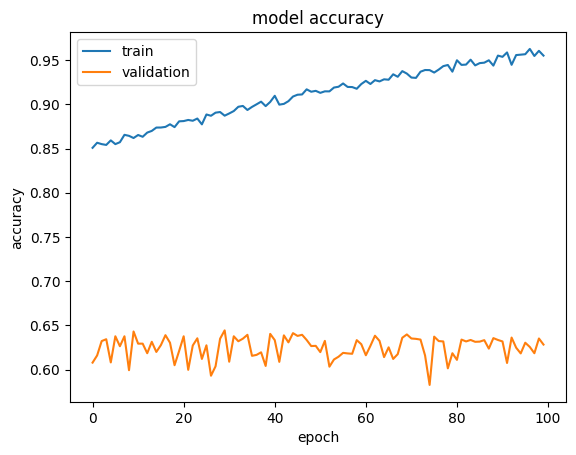

In [65]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()